# Tensorflow mechanics exploration

Purpose of this notebook to provide a more comprehensive description of how internelly works Tensorflow and its graph/ops mechanics.

This text is not intended to replace tensorflow tutorials and programming guides.

In [1]:
import tensorflow as tf

## Graph and dataflow

Following [this guide](https://www.tensorflow.org/programmers_guide/graphs) or [this doc](https://www.tensorflow.org/api_guides/python/framework#Core_graph_data_structures) on graphs, [`tf.Graph`](https://www.tensorflow.org/api_docs/python/tf/Graph) contains two relevant kinds of information:


- **Graph structure**: a set of [`tf.Operation`](https://www.tensorflow.org/api_docs/python/tf/Operation) objects, which represent units of computation (nodes) and [`tf.Tensor`](https://www.tensorflow.org/api_docs/python/tf/Tensor) objects, which represent the units of data that flow between operations (edges).

    - Operations (nodes) can be obtained with `tf.Graph.get_operations()`. 
    - An `Operation` is a node in a TensorFlow `Graph` that takes zero or more `Tensor` objects as input, and produces zero or more Tensor objects as output.
    - Tensor is one of the outputs of an operation: `tf.Operation.outputs`.

- **Graph collections**: dictionary that stores various objects, referenced by keys (standard `tf.GraphKeys` and user-defined). 
    - Collections can be fetched with `tf.Graph._collections` or `tf.Graph.collections` for version >= 1.3

### Graph structure


In [2]:
def print_graph_structure(graph):
    print("--- Graph structure ---")
    print("\n - Operations (nodes): \n")
    for o in graph.get_operations():
        print(repr(o))
    # Get all tensors:
    tensors = set()
    for op in graph.get_operations():
        for t in op.outputs:
            tensors.add(t)
    print("\n - Tensors (edges): \n")
    for t in tensors:
        print(t)

    print("\n - Collections: \n")
    print("    keys: %s" % list(graph._collections.keys()))
    for k in graph._collections:
        print("    ", k, " : ", graph._collections[k])

tf.reset_default_graph()
graph = tf.get_default_graph()
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 


 - Tensors (edges): 


 - Collections: 

    keys: []


In [3]:
a = tf.placeholder(dtype=tf.float32, name='a')
b = tf.placeholder(dtype=tf.float32, name='b')
_ = tf.matmul(a, b, name='matmul')

In [4]:
graph = tf.get_default_graph()
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 

<tf.Operation 'a' type=Placeholder>
<tf.Operation 'b' type=Placeholder>
<tf.Operation 'matmul' type=BatchMatMul>

 - Tensors (edges): 

Tensor("a:0", dtype=float32)
Tensor("b:0", dtype=float32)
Tensor("matmul:0", dtype=float32)

 - Collections: 

    keys: []


Let's visualize the graph

In [5]:
from graphviz import Digraph

def tf_to_dot(graph, display_all_nodes=False):
    dot = Digraph()
    node_ops_to_skip = ['Const', 'RandomUniform', 'Assign', 'AssignAdd',
                        'Identity', 'VariableV2', 'Shape', 'StridedSlice', 'Pack']
    node_names_to_skip = ['random', 'flatten/Prod']
    for n in graph.as_graph_def().node:
        if not display_all_nodes:
            if n.op in node_ops_to_skip:
                continue
            skip = False
            for name_to_skip in node_names_to_skip:
                if name_to_skip in n.name:
                    skip = True
                    break
            if skip:
                continue
        dot.node(n.name, label=n.name)
        for i in n.input:
            dot.edge(i, n.name)            
    return dot

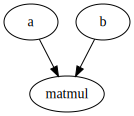

In [6]:
tf_to_dot(graph, display_all_nodes=True)

### Constants, variables and graph collections


- **Constants**: Creating a `tf.constant` creates a `tf.Operation` and adds it to the default graph and returns a `tf.Tensor` that represents the value.

- [**Variables**](https://www.tensorflow.org/programmers_guide/variables): Creating a [`tf.Variable`](https://www.tensorflow.org/api_docs/python/tf/Variable) adds to the graph a `tf.Operation` that will store a writeable tensor value that persists between `tf.Session.run` calls. 

By default every `tf.Variable` gets placed in the following two collections: 
* `tf.GraphKeys.GLOBAL_VARIABLES` --- variables that can be shared across multiple devices, 
* `tf.GraphKeys.TRAINABLE_VARIABLES` --- variables for which TensorFlow will calculate gradients.


In [7]:
tf.reset_default_graph()
c = tf.constant(1.2345, name='1.2345_constant')
v = tf.Variable(initial_value=0.0, dtype=tf.float32, name="Trainable_variable")
v2 = tf.Variable(initial_value=0.0, trainable=False, dtype=tf.float32, name="Non-trainable_variable")

In [8]:
graph = tf.get_default_graph()
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 

<tf.Operation '1.2345_constant' type=Const>
<tf.Operation 'Trainable_variable/initial_value' type=Const>
<tf.Operation 'Trainable_variable' type=VariableV2>
<tf.Operation 'Trainable_variable/Assign' type=Assign>
<tf.Operation 'Trainable_variable/read' type=Identity>
<tf.Operation 'Non-trainable_variable/initial_value' type=Const>
<tf.Operation 'Non-trainable_variable' type=VariableV2>
<tf.Operation 'Non-trainable_variable/Assign' type=Assign>
<tf.Operation 'Non-trainable_variable/read' type=Identity>

 - Tensors (edges): 

Tensor("Trainable_variable/read:0", shape=(), dtype=float32)
Tensor("Non-trainable_variable/Assign:0", shape=(), dtype=float32_ref)
Tensor("1.2345_constant:0", shape=(), dtype=float32)
Tensor("Non-trainable_variable:0", shape=(), dtype=float32_ref)
Tensor("Non-trainable_variable/initial_value:0", shape=(), dtype=float32)
Tensor("Trainable_variable:0", shape=(), dtype=float32_ref)
Tensor("Trainable_variable/initial_val

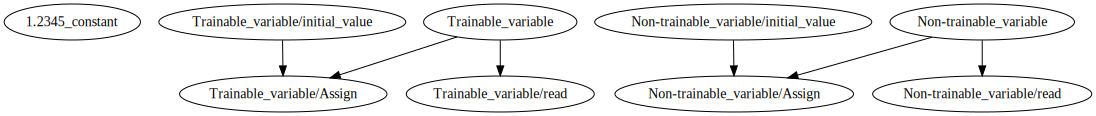

In [9]:
tf_to_dot(graph, display_all_nodes=True)

### Session run  and `control_dependencies`

Once graph is built we can execute its computation within a session.

Let's consider two examples that compute a normalized value from an input value:
```
y = (x - mean) / (variance + eps)
```
in the first version mean and variance are constant and in the second they are computed with exponential moving decay.

#### Constant mean/variance

In [10]:
tf.reset_default_graph()
graph = tf.get_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=(1, ), name='X')
mean = tf.Variable(initial_value=0.0, trainable=False, name='X_mean')
variance = tf.Variable(initial_value=1.0, trainable=False, name='X_variance')
eps = tf.constant(1e-10, dtype=tf.float32, name='Epsilon')
y = tf.identity((x - mean) / (variance + eps), name='Y')

In [11]:
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 

<tf.Operation 'X' type=Placeholder>
<tf.Operation 'X_mean/initial_value' type=Const>
<tf.Operation 'X_mean' type=VariableV2>
<tf.Operation 'X_mean/Assign' type=Assign>
<tf.Operation 'X_mean/read' type=Identity>
<tf.Operation 'X_variance/initial_value' type=Const>
<tf.Operation 'X_variance' type=VariableV2>
<tf.Operation 'X_variance/Assign' type=Assign>
<tf.Operation 'X_variance/read' type=Identity>
<tf.Operation 'Epsilon' type=Const>
<tf.Operation 'sub' type=Sub>
<tf.Operation 'add' type=Add>
<tf.Operation 'truediv' type=RealDiv>
<tf.Operation 'Y' type=Identity>

 - Tensors (edges): 

Tensor("X_mean:0", shape=(), dtype=float32_ref)
Tensor("X_mean/Assign:0", shape=(), dtype=float32_ref)
Tensor("X_variance/Assign:0", shape=(), dtype=float32_ref)
Tensor("X_variance/read:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Tensor("X_mean/read:0", shape=(), dtype=float32)
Tensor("X_mean/initial_value:0", shape=(), dtype=floa

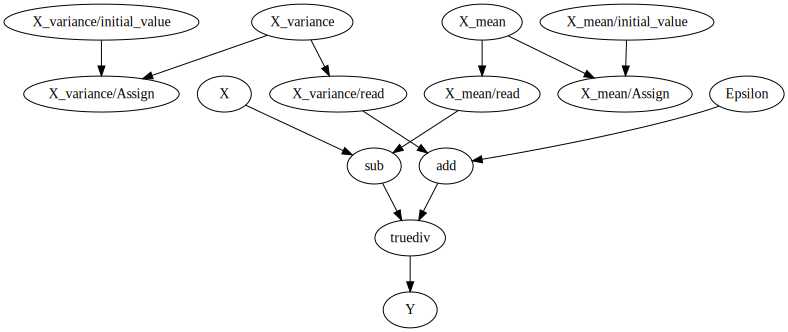

In [12]:
tf_to_dot(graph, display_all_nodes=True)

In [13]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [14]:
n = 100
with tf.Session() as sess, graph.as_default():

    res = np.zeros((n, 2))
    for i in range(n):
        feed_dict = {
            x: np.sin(2.0 / 12.0 *np.pi* i ) + np.random.randn(1),
            mean: 5.0,
            variance: 2.0
        }
        res[i, 0] = sess.run(x, feed_dict=feed_dict)
        res[i, 1] = sess.run(y, feed_dict=feed_dict)        

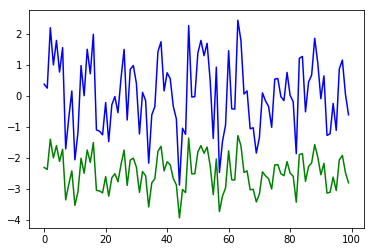

In [15]:
plt.plot(res[:, 0], 'b')
plt.plot(res[:, 1], 'g')

#### Variable mean/variance

In [16]:
tf.reset_default_graph()
graph = tf.get_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=(1, ), name='X')

# Create an ExponentialMovingAverage object
ema = tf.train.ExponentialMovingAverage(decay=0.9999)

mean = tf.Variable(initial_value=x, name='X_mean')
variance = tf.Variable(initial_value=(x - mean), name='X_variance')

maintain_averages_op = ema.apply([mean, variance])

eps = tf.constant(1e-10, dtype=tf.float32, name='Epsilon')

# The following updates mean/variance before computing y
with tf.control_dependencies([mean, variance]):
    y = tf.identity((x - mean) / (variance + eps), name='Y')

In [17]:
print_graph_structure(graph)

--- Graph structure ---

 - Operations (nodes): 

<tf.Operation 'X' type=Placeholder>
<tf.Operation 'X_mean' type=VariableV2>
<tf.Operation 'X_mean/Assign' type=Assign>
<tf.Operation 'X_mean/read' type=Identity>
<tf.Operation 'sub' type=Sub>
<tf.Operation 'X_variance' type=VariableV2>
<tf.Operation 'X_variance/Assign' type=Assign>
<tf.Operation 'X_variance/read' type=Identity>
<tf.Operation 'IsVariableInitialized' type=IsVariableInitialized>
<tf.Operation 'cond/Switch' type=Switch>
<tf.Operation 'cond/switch_t' type=Identity>
<tf.Operation 'cond/switch_f' type=Identity>
<tf.Operation 'cond/pred_id' type=Identity>
<tf.Operation 'cond/read/Switch' type=RefSwitch>
<tf.Operation 'cond/read' type=Identity>
<tf.Operation 'cond/Switch_1' type=Switch>
<tf.Operation 'cond/Merge' type=Merge>
<tf.Operation 'X_mean/ExponentialMovingAverage' type=VariableV2>
<tf.Operation 'X_mean/ExponentialMovingAverage/Assign' type=Assign>
<tf.Operation 'X_mean/ExponentialMovingAverage/read' type=Identity>
<tf.Op

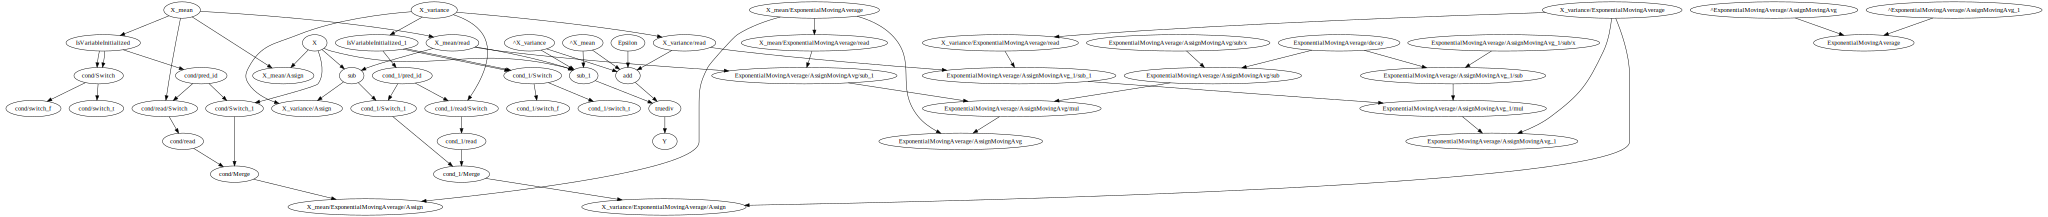

In [18]:
tf_to_dot(graph, display_all_nodes=True)

In [19]:
n = 100
with tf.Session() as sess, graph.as_default():

    res = np.zeros((n, 2))
    for i in range(n):
        feed_dict = {
            x: np.sin(2.0 / 12.0 *np.pi* i ) + np.random.randn(1),
        }
        res[i, 0] = sess.run(x, feed_dict=feed_dict)
        res[i, 1] = sess.run(y, feed_dict=feed_dict)        

FailedPreconditionError: Attempting to use uninitialized value X_mean
	 [[Node: X_mean/read = Identity[T=DT_FLOAT, _class=["loc:@X_mean"], _device="/job:localhost/replica:0/task:0/gpu:0"](X_mean)]]
	 [[Node: Y/_3 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_15_Y", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'X_mean/read', defined at:
  File "/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-224567ebfca1>", line 9, in <module>
    mean = tf.Variable(initial_value=x, name='X_mean')
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 316, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1338, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value X_mean
	 [[Node: X_mean/read = Identity[T=DT_FLOAT, _class=["loc:@X_mean"], _device="/job:localhost/replica:0/task:0/gpu:0"](X_mean)]]
	 [[Node: Y/_3 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_15_Y", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


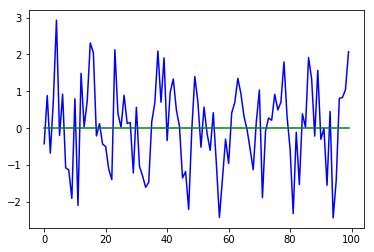

In [156]:
plt.plot(res[:, 0], 'b')
plt.plot(res[:, 1], 'g')

In [1]:
import tensorflow as tf

In [ ]:
y = tf.matmul([[37.0, -23.0], [1.0, 4.0]], tf.random_uniform([2, 2]))

with tf.Session() as sess:
    # Define options for the `sess.run()` call.
    options = tf.RunOptions()
    options.output_partition_graphs = True
    options.trace_level = tf.RunOptions.FULL_TRACE

    # Define a container for the returned metadata.
    metadata = tf.RunMetadata()

    sess.run(y, options=options, run_metadata=metadata)

    # Print the subgraphs that executed on each device.
    print(metadata.partition_graphs)

    # Print the timings of each operation that executed.
    print(metadata.step_stats)
